In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv, TopKPooling, global_mean_pool as gap, global_max_pool as gmp
import torch_geometric.nn
from torch_geometric.loader import DataLoader
from torch.optim import Adam
from sklearn.metrics import accuracy_score
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops


/Applications/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/Applications/anaconda3/lib/python3.11/site-packages/torch_sparse/_convert_cpu.so, 0x0006): symbol not found in flat namespace '__ZN2at8internal15invoke_parallelExxxRKNSt3__18functionIFvxxEEE'
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
node_features = pd.read_csv('preprocessed_node_features.csv')

/var/folders/9m/5shl5b5577q1b4pkqshrp5980000gn/T/ipykernel_64237/3506719987.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

In [3]:
edge_features = pd.read_csv('preprocessed_edge_features.csv')

In [4]:
node_features_numeric = node_features.select_dtypes(include=['number', 'bool'])  # Include numeric and boolean columns

if 'root_id' in node_features_numeric.columns:
    node_features_numeric = node_features_numeric.drop(columns=['root_id'])



In [5]:
node_features_tensor = torch.tensor(node_features_numeric.values, dtype=torch.float)

In [6]:
id_to_index = {root_id: idx for idx, root_id in enumerate(node_features['root_id'])} # PyTorch Geometric GNN works with nodes referenced by integer indices not arbitrary IDs

edge_features['pre_root_id'] = edge_features['pre_root_id'].map(id_to_index)
edge_features['post_root_id'] = edge_features['post_root_id'].map(id_to_index)

# Remove rows with unmapped IDs
edge_features = edge_features.dropna(subset=['pre_root_id', 'post_root_id']).astype({'pre_root_id': int, 'post_root_id': int})

edge_index = torch.tensor(edge_features[['pre_root_id', 'post_root_id']].values.T, dtype=torch.long) # standard edge representation used in PyTorch Geometric


In [7]:
labels = torch.tensor(node_features['nt_type'].factorize()[0], dtype=torch.long)

In [8]:
data = Data(
    x=node_features_tensor,
    edge_index=edge_index
)

In [9]:
data.y = torch.tensor(labels, dtype=torch.long) # true labels

/var/folders/9m/5shl5b5577q1b4pkqshrp5980000gn/T/ipykernel_64237/2186120499.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.y = torch.tensor(labels, dtype=torch.long) # true labels


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_squared_error

# Define the AdvancedGNN for graph-level regression
class EdgePredictorGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(EdgePredictorGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, 1)  # Single output for edge count regression

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # GNN layers
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        # Global pooling to get graph-level representation
        x = global_mean_pool(x, batch)

        # Fully connected layer for regression
        x = self.fc(x)
        return x


In [11]:
data.edge_count = torch.tensor([data.edge_index.size(1)], dtype=torch.float)  # Example target

data.edge_count = data.edge_count / data.edge_count.max()  # Normalize between 0 and 1


# DataLoader
train_loader = DataLoader([data], batch_size=1, shuffle=True)
val_loader = DataLoader([data], batch_size=1, shuffle=False)

# Model setup
input_dim = data.x.shape[1] 
hidden_dim = 64

model = EdgePredictorGNN(input_dim=input_dim, hidden_dim=hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        out = model(batch)

        loss = loss_fn(out.squeeze(), batch.edge_count.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation loop
    model.eval()
    epoch_val_loss = 0
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in val_loader:
            out = model(batch)
            val_loss = loss_fn(out.squeeze(), batch.edge_count.squeeze())
            epoch_val_loss += val_loss.item()
            predictions.append(out.item())
            targets.append(batch.edge_count.item())
        
        

    val_losses.append(val_loss / len(val_loader))
    mse = mean_squared_error(targets, predictions)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, MSE: {mse:.4f}")

# Test performance
model.eval()
with torch.no_grad():
    predictions = []
    targets = []
    for batch in val_loader:
        out = model(batch)
        predictions.append(out.item())
        targets.append(batch.edge_count.item())

    mse = mean_squared_error(targets, predictions)
    print(f"Mean Squared Error on Validation Data: {mse:.4f}")


Epoch 1, Train Loss: 1239.2045, Val Loss: 783.9483, MSE: 783.9483
Epoch 2, Train Loss: 783.9483, Val Loss: 436.6780, MSE: 436.6780
Epoch 3, Train Loss: 436.6780, Val Loss: 194.9743, MSE: 194.9743
Epoch 4, Train Loss: 194.9743, Val Loss: 53.3090, MSE: 53.3090
Epoch 5, Train Loss: 53.3090, Val Loss: 1.1287, MSE: 1.1287
Epoch 6, Train Loss: 1.1287, Val Loss: 20.2168, MSE: 20.2168
Epoch 7, Train Loss: 20.2168, Val Loss: 79.6472, MSE: 79.6472
Epoch 8, Train Loss: 79.6472, Val Loss: 142.6506, MSE: 142.6506
Epoch 9, Train Loss: 142.6506, Val Loss: 184.2438, MSE: 184.2438
Epoch 10, Train Loss: 184.2438, Val Loss: 196.2921, MSE: 196.2921
Epoch 11, Train Loss: 196.2921, Val Loss: 182.4502, MSE: 182.4502
Epoch 12, Train Loss: 182.4502, Val Loss: 151.3262, MSE: 151.3263
Epoch 13, Train Loss: 151.3262, Val Loss: 112.1843, MSE: 112.1843
Epoch 14, Train Loss: 112.1843, Val Loss: 73.0781, MSE: 73.0781
Epoch 15, Train Loss: 73.0781, Val Loss: 39.9213, MSE: 39.9213
Epoch 16, Train Loss: 39.9213, Val Los

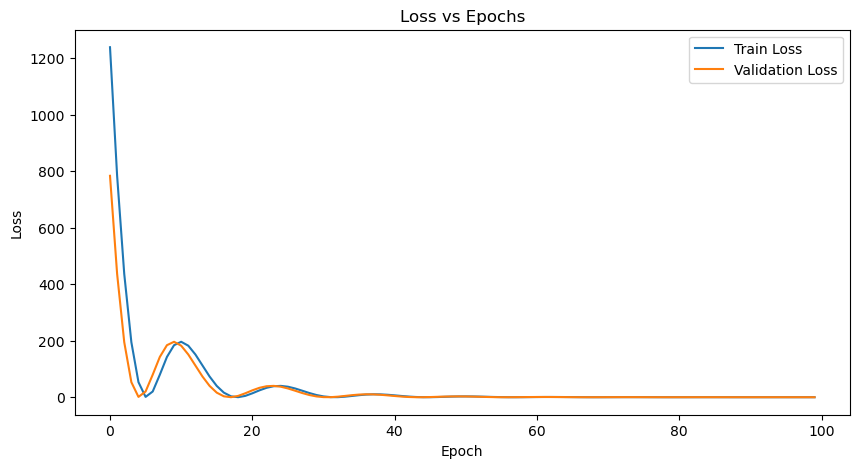

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()